# Reproducible code
For maximal reproducibility, we recommend to run the "Create_VirtualEnv....ipynb", using the default shell of your OS or bash. You are then required to change the current notebook's kernel to "RadTMSR_env", which stores all required versions of the used modules.

**Written in Python 4.20.11 and Jupyter Lab 4.0.7**


In [1]:
input("Reassure that Kernel is set to RadTMSR_env before continuing")

Reassure that Kernel is set to RadTMSR_env before continuing 


''

In [2]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import subprocess
import spacy
nlp = spacy.load('en_core_web_sm')
import networkx as nx
from scipy.stats import binom_test

#### **To run this script successfully, R has to be installed and Rscript.exe has to be in the local environment's PATH.**

To ensure that Rscript.exe is in the PATH, follow the following steps:

1. Run the cell below. If Rscript.exe is found, you are informed that R scripts can be run successfully. Otherwise, you are required to input the absolute directory of the Rscript.exe. To this end, follow the following guidance:

2. Locate the Rscript.exe file, usually in the bin folder of your R installation directory. The path might look something like C:\Program Files\R\R-x.x.x\bin.

In [3]:
try:
    result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
    print("Rscript version:", result.stdout)
    print("R scripts can be successfully run.")
    
except FileNotFoundError:
    rscript_path = input("Rscript.exe not found. Please enter the absolute directory path where Rscript.exe is located: ")
    print("Absolute path provided: ", rscript_path)
    
    # Add the path to the PATH environment variable for the current session
    os.environ['PATH'] += os.pathsep + rscript_path
    
    # Verify if Rscript is accessible this time
    try:
        result = subprocess.run(['Rscript', '--version'], capture_output=True, text=True)
        print("Rscript version:", result.stdout)
        print("R scripts can be successfully run.")
    except FileNotFoundError:
        raise Exception("Rscript not found. Please check the path.")

Rscript version: Rscript (R) version 4.3.2 (2023-10-31)

R scripts can be successfully run.


## Study 2 - Abstract Analysis

In [4]:
# Import data
dfTot = pd.read_excel("asreview_dataset_relevant_Radicalization.xlsx")
#dfTot.head()

In [5]:
data = dfTot[["record_id","Abstract"]].copy()
data.rename(columns={'Abstract': 'abstract'}, inplace=True)

In [6]:
data = data.dropna(subset = ['abstract']).reset_index(drop=True)
data

,record_id,abstract
0,50129,This research examines how the relationship be...
1,2624,Religion is often seen as one of the main caus...
2,35510,Why are some people capable of sympathizing wi...
3,43427,In this study among Dutch Muslim youth (N= 131...
4,986,Despite its prominence in radicalization model...
...,...,...
4014,24073,This article focuses on the place and role of ...
4015,22510,Islamist militancy is not a new phenomenon in ...
4016,50382,Results of an empirical study of long-term goa...
4017,2188,The purpose of this study is to examine the ef...


# Preprocessing

**Pipeline**:

`data` --> `pre-processing`

* strip punctuation, exclude non-letters, but keep "-" between words
* part-of-speech tagging - retain adjectives and nouns only
* lower case
* lemmatise

--> `exclusion filter (stopwords, countries, exclusion terms)` --> `n-gram extraction`

* 1 - 3-grams

--> `classification and replacement`

* Replace according to dictionary order (vs. overlapping as in keywords) ?




--> `tokenbydoc` --> *transfer to R* --> `negative binomial` --> `topic modelling` --> `frequence analysis` --> `co-occurrence analysis` --> *transfer to Python* --> `co-occurrence network map`

### 1. Cleaning

In [7]:
from Word_functions.word_functions_py import strip_characters, POS_tagging, lemmatisation

**strip punctuation, exclude non-letters**

In [8]:
data.abstract[4014]

"This article focuses on the place and role of women in the ideology of the Greek neo-Nazi political party Golden Dawn (GD). The article considers the place of women in GD's ideology as well as how GD envisages the role of women in society. It asks whether this vision of women's role is reflected in the participation of women in the party's activities. Based on a content analysis of material derived from the party's official websites, it is argued that women play a key role in GD's ideological edifice. This is evident in the party's concern with the construction of a nationalist habitus for women. This habitus is rooted in ideas of anti-feminism, motherhood and family and the primacy of nation and nationalist sentiment in determining women's lives."

In [9]:
data.abstract = data.abstract.apply(strip_characters)

In [10]:
data.abstract[4014]

'This article focuses on the place and role of women in the ideology of the Greek neo Nazi political party Golden Dawn GD The article considers the place of women in GD ideology as well as how GD envisages the role of women in society It asks whether this vision of women role is reflected in the participation of women in the party activities Based on a content analysis of material derived from the party official websites it is argued that women play a key role in GD ideological edifice This is evident in the party concern with the construction of a nationalist habitus for women This habitus is rooted in ideas of anti feminism motherhood and family and the primacy of nation and nationalist sentiment in determining women lives'

**POS tagging**

In [11]:
data.abstract = data.abstract.apply(POS_tagging)

In [12]:
data.abstract[4014]

'article place role women ideology Greek neo political party article place women ideology role women society vision women role participation women party activities content analysis material party official websites women key role ideological edifice evident party concern construction nationalist habitus women habitus ideas anti feminism motherhood family primacy nation nationalist sentiment women lives'

**lower case**

In [13]:
data.abstract = data.abstract.apply(lambda x: " ".join([str(item).lower() for item in x.split(" ")]))

In [14]:
data.abstract[4014]

'article place role women ideology greek neo political party article place women ideology role women society vision women role participation women party activities content analysis material party official websites women key role ideological edifice evident party concern construction nationalist habitus women habitus ideas anti feminism motherhood family primacy nation nationalist sentiment women lives'

**lemmatisation**

In [15]:
data.abstract = data.abstract.apply(lemmatisation)

In [16]:
data.abstract[4014]

'article place role woman ideology greek neo political party article place woman ideology role woman society vision woman role participation woman party activity content analysis material party official website woman key role ideological edifice evident party concern construction nationalist habitus woman habitus ideas anti feminism motherhood family primacy nation nationalist sentiment woman live'

### 2. Exclusion filter

In [17]:
from stop_words import get_stop_words
stoplist = get_stop_words('en')
from country_list import countries_for_language
countries_dict = dict(countries_for_language('en'))
countries_raw = list(countries_dict.values())
countries = [term.lower() for term in countries_raw]

In [18]:
exclusion_list = pd.read_excel("Exclusion_def.xlsx")
excl_list = list(exclusion_list.Exclusion)
excl_list = [str(item) for item in excl_list]
region_list = ['africa','asia','europe','america','middle east',
               "western europe", "northern ireland", "hong kong", "basque country",
               "eastern europe", "southeast asia", "south asia", "somali", "britain", "latin america", "central asia",
               "palestine", 'middle east and north africa', "european country", "c", "elsevi"]

In [19]:
exclusion_filter = set(excl_list + countries + stoplist + region_list)
exclusion_filter_string = "\\b" + " \\b|\\b".join(exclusion_filter) + " \\b"

In [20]:
data.abstract = data.abstract.apply(lambda x: re.sub(exclusion_filter_string, "", x))
#data

In [21]:
data.to_json('RTMR_Output/data_processed_study2.json', orient='records', lines=True)

### 3. N-gram extraction

In [22]:
#data = pd.read_json('RTMR_Output/data_processed_study2.json', orient='records', lines=True)

In [23]:
from Word_functions.word_functions_py import ngram_extractor, trigram_to_nounbydoc, bigram_to_nounbydoc, relevant_trigrams, select_unigrams, to_nounbydoc

In [24]:
data.abstract = data.abstract.apply(lambda x: x.split(" "))

In [25]:
# remove consecutive duplicates
data.abstract = data.abstract.apply(lambda x: [element for idx, element in enumerate(x) if idx == 0 or element != x[idx-1]])

In [26]:
data["ngram"] = data.abstract.apply(ngram_extractor)

#### Identifying meaningful n-grams 

**Workflow**:

1. N-grams can be considered meaningful if they occur above chance.
2. To this end, the occurrence of trigrams will be modelled with a negative binomial distribution

In [27]:
trigram_nounbydoc = trigram_to_nounbydoc(data)
#trigram_nounbydoc

In [28]:
trigram_nounbydoc.to_csv("RTMR_Output/trigram_nounbydoc.csv", index=False)

In [29]:
os.chdir("Word_functions")
r_script_path = 'trigrams_pruning.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

R script ran successfully


In [30]:
meaningful_trigrams = list(pd.read_csv("RTMR_Output/trigrams_pruned.csv").Word)

In [31]:
data[["trigrams","residual_ngrams"]] = data.ngram.apply(lambda x: pd.Series(relevant_trigrams(x, meaningful_trigrams)))

In [32]:
data.head()

,record_id,abstract,ngram,trigrams,residual_ngrams
0,50129,"[relationship, passion, ideology, violent, act...","[[relationship passion ideology, relationship ...","[collective loss significance, obsessive harmo...","[relationship passion, passion ideology, ideol..."
1,2624,"[religion, main, extremist, violence, suicide,...","[[religion main extremist, religion main], [ma...",[support extremist violence],"[religion main, main extremist, extremist viol..."
2,35510,"[capable, andor, act, political, violence, att...","[[capable andor act, capable andor], [andor ac...","[extreme political violence, radicalization po...","[capable andor, andor act, nan, violence attac..."
3,43427,"[dutch, muslim, youth, radicalization, main, p...","[[dutch muslim youth, dutch muslim], [muslim y...",[],"[dutch muslim, muslim youth, youth radicalizat..."
4,986,"[prominence, understand, extent, identity, ext...","[[prominence understand extent, prominence und...",[],"[prominence understand, understand extent, ext..."


**Next step: selecting meaningful 2-grams**

In [33]:
bigrams_nounbydoc = bigram_to_nounbydoc(data)
#bigrams_nounbydoc

In [34]:
bigrams_nounbydoc.to_csv("RTMR_Output/bigrams_nounbydoc.csv",index=False)

In [35]:
os.chdir("Word_functions")
r_script_path = 'bigrams_pruning.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

R script ran successfully


In [36]:
meaningful_bigrams = list(pd.read_csv("RTMR_Output/bigrams_pruned.csv").Word)

In [37]:
data["bigrams"] = data.residual_ngrams.apply(lambda x: list(set([element for element in x if element in meaningful_bigrams])))

**Combining meaningful trigrams, bigrams, and unigrams**

In [38]:
select_unigrams(data)

In [39]:
#data.drop("residual_ngrams",axis=1,inplace=True)
data['keywords'] = data.apply(lambda row: list(set(row['trigrams'] + row['bigrams'] + row['resid_onegrams'])), axis=1)
#data['keywords'] = data.apply(lambda row: list(set(row['trigrams'] + row['bigrams'])), axis=1)
#data.head()

### 4. Classification and Replacement

In [40]:
data.to_json('RTMR_Output/data_ready_study2.json', orient='records', lines=True)
#data = pd.read_json('RTMR_Output/data_ready_study2.json', orient='records', lines=True)

In [41]:
from TMSR_dictionary import word_dict
from Word_functions.word_functions_py import classification, extend_keywords

========================================================================================================

In [42]:
keywords_list = sum(data.keywords, [])
len(keywords_list)

154576

In [43]:
count_dict, uniques, terms_in_cat_dict = classification(keywords_list,word_dict)

In [44]:
#print(f"{len(uniques)} not classified keywords, with {len(set(uniques))} unique terms.")

**Arnis playground 2.0**

In [45]:
print(terms_in_cat_dict["language"])

Counter({'rhetoric': 91, 'language': 84, 'linguistic': 41, 'speech': 41, 'rhetorical': 18, 'verbal': 14, 'english language': 7, 'extremist language': 7, 'populist rhetoric': 7, 'violent rhetoric': 6, 'use language': 5, 'linguistic fractionalization': 5, 'political rhetoric': 5, 'rhetoric violence': 4, 'rhetoric radical': 4, 'religious rhetoric': 2, 'multilingual': 2, 'lingual': 2, 'linguistical': 1, 'psycholinguistic': 1, 'multilingualism': 1, 'corpuslinguistic': 1})


In [46]:
from collections import Counter
 
#frequency = Counter(uniques)
#print(frequency)

======================================================================================================================================

In [47]:
clean_data = data.copy(deep = True)
clean_data["cat_keywords"] = clean_data.keywords.apply(lambda x: extend_keywords(x,word_dict))

**keep categories, 2-3grams, discard single words**

In [48]:
clean_data["cat_keywords2"] = clean_data.cat_keywords.apply(lambda x: [token for token in x if token in list(word_dict.keys()) or " " in token])

In [49]:
nounbydoc = to_nounbydoc(clean_data, "cat_keywords2")
nounbydoc.to_csv(r"RTMR_Output/nounbydoc_study2.csv", index = False)

In [50]:
clean_data.to_json("RTMR_Output/clean_data_study2.json", orient='records', lines=True)
#clean_data = pd.read_json("RTMR_Output/clean_data_study2.json", orient='records', lines=True)

In [51]:
print(f"Total number of keywords: {len(nounbydoc.term)}")
print(f"Number of unique keywords: {len(set(nounbydoc.term))}")

frequency = Counter(nounbydoc.term)
one_hit_wonders = [term for term, n in frequency.items() if n == 1]
print("Number of terms occurring only once: ", len(one_hit_wonders))

Total number of keywords: 44687
Number of unique keywords: 2204
Number of terms occurring only once:  33


===========================================================================================================================

### Run R script for:
* Negative Binomial (Pruning)
* Word Frequency
* Topic Modelling
* Term co-occurrences

##### using van Lissa's R code
  
===========================================================================================================================

In [52]:
os.chdir("Word_functions")
r_script_path = 'Keywords_RTMR_study2.R'
result = subprocess.run(['Rscript', r_script_path], capture_output=True, text=True)
os.chdir("..")

if result.returncode == 0:
    print("R script ran successfully")
else:
    print("Error in running R script")
    print(result.stderr)
    raise Exception("an error occurred")

R script ran successfully


## I. Word Frequency

In [53]:
freq_df = pd.read_csv(r"RTMR_Output/Keywords_freq_study2.csv").sort_values(by= "Frequency", ascending=False).reset_index()
len(freq_df)

78

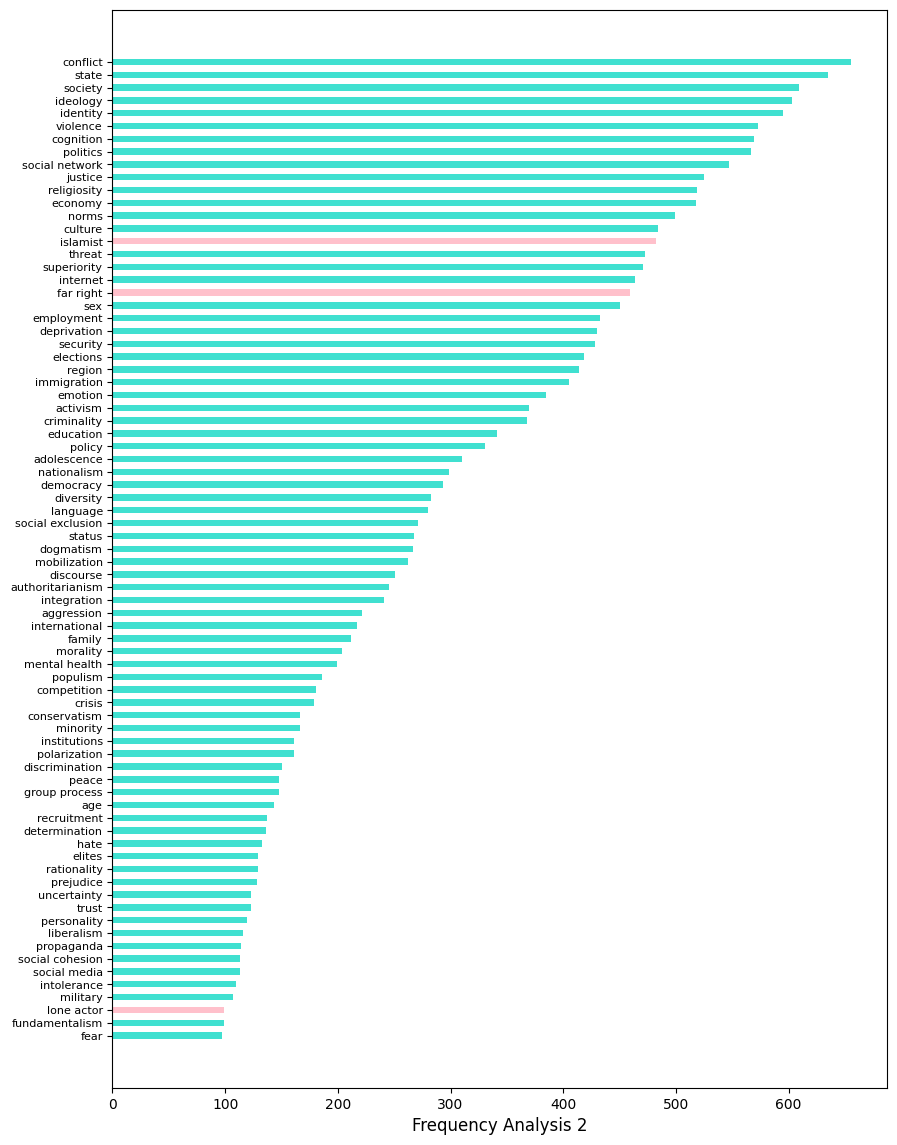

In [54]:
plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)
#plt_df = freq_df
highlight_words = ['far right', "far left", "islamist", "lone actor", "foreign fighter"]
colors = ['turquoise' if word not in highlight_words else 'pink' for word in plt_df['Word']]

plt.figure(figsize=(10,14))
plt.barh(plt_df['Word'], plt_df['Frequency'], color=colors, height = 0.5)

plt.xlabel('Frequency Analysis 2', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)

plt.savefig('RTMR_Output/abstractsfull_frequency_of_words.png', bbox_inches='tight', dpi=600)


======================================================================================================

**for poster**

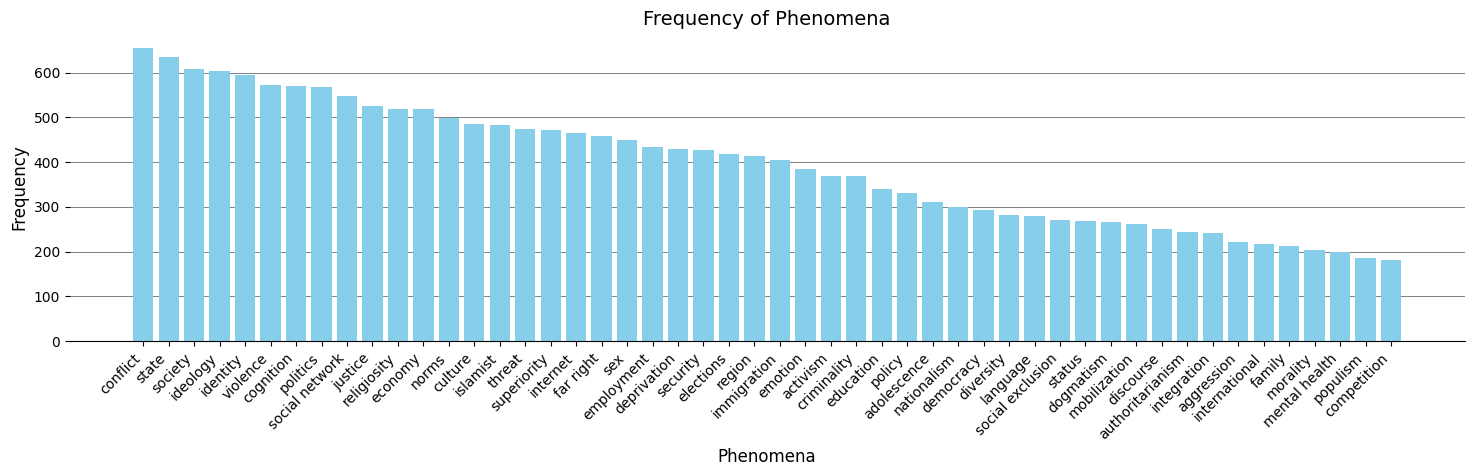

In [55]:
# Filter out the word "radicalism" and sort by frequency
plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by="Frequency", ascending=False).head(50)

highlight_words = []  # You can specify any words you want to highlight
colors = ['skyblue' if word not in highlight_words else 'pink' for word in plt_df['Word']]

plt.figure(figsize=(18, 4))
plt.bar(plt_df['Word'], plt_df['Frequency'], color=colors)

plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Phenomena', fontsize=12)
plt.title('Frequency of Phenomena', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Remove the black frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle='-', linewidth=0.7, color='gray')
ax.set_axisbelow(True)

plt.savefig('RTMR_Output/abstracts_frequency_of_words.png', bbox_inches='tight', dpi=600)
plt.show()




## Frequency with categories

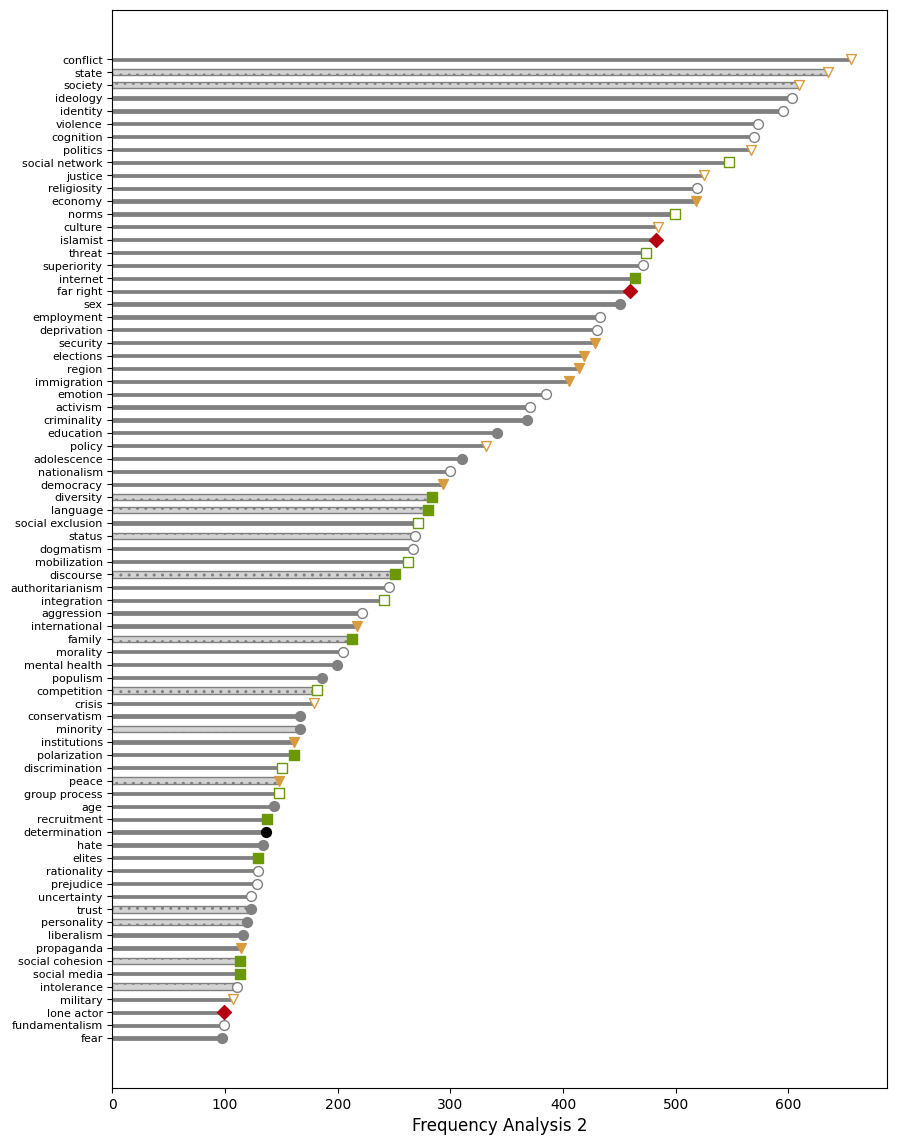

In [56]:
# Define the categorization
micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "misogyny"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)

plt.figure(figsize=(10, 14))

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes for categories in the foreground
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes for categories in the foreground with white filling
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

plt.xlabel('Frequency Analysis 2', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)
plt.savefig('RTMR_Output/abstractsfull_frequency_of_words.png', bbox_inches='tight', dpi=600)


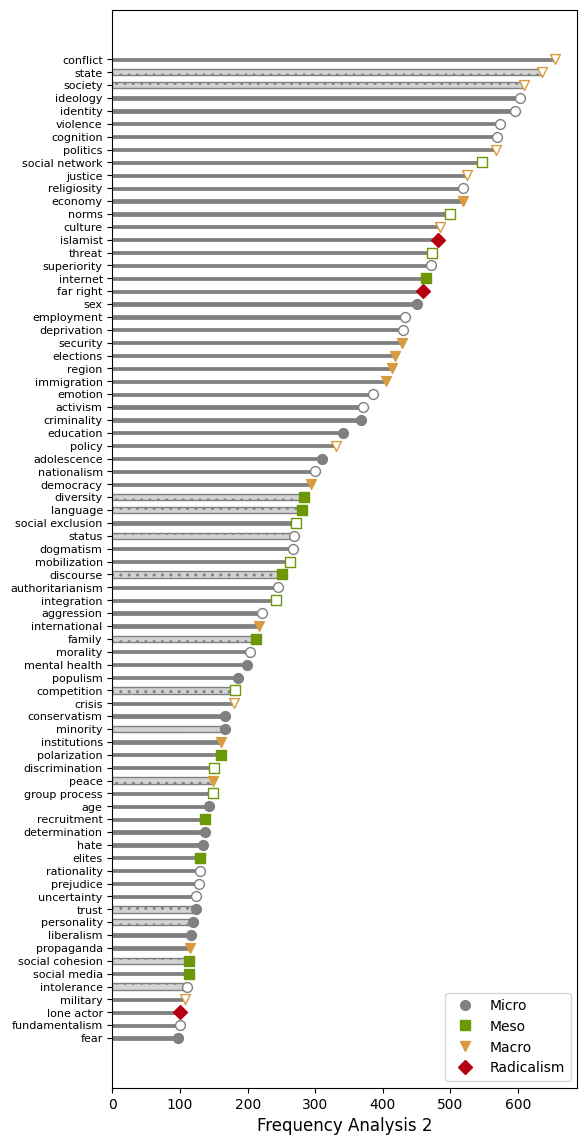

In [57]:
# Define the categorization
micro_terms = ["ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
               "sex", "employment", "deprivation", "emotion", "activism", "criminality", 
               "education", "nationalism", "populism", "status", "dogmatism", "authoritarianism", 
               "aggression", "morality", "mental health", "conservatism", "minority", 
               "sacred values", "age", "hate", "rationality", "prejudice", "uncertainty", 
               "trust", "personality", "liberalism", "intolerance", "fundamentalism", "fear", 
               "honor", "poverty", "white race", "superiority", "islamophobia", 
               "significance quest", "social movements", "masculinity", "conspiracy", 
               "misogyny", "racism", "martyrdom", "political engagement", "ptsd", "resilience", 
               "voting behavior", "determination"]

meso_terms = ["social network", "threat", "diversity", "social exclusion", "norms", "internet", 
              "mobilization", "discourse", "integration", "family", "competition", "language", 
              "polarization", "discrimination", "group process", "recruitment", "elites", 
              "social media", "social cohesion", "social change"]

macro_terms = ["conflict", "state", "economy", "society", "politics", "justice", "culture", 
               "security", "region", "elections", "policy", "democracy", "international", 
               "crisis", "institutions", "peace", "propaganda", "military", "globalization", 
               "immigration"]

theory_terms = ["ideology", "violence", "social network", "conflict", "religiosity", "state", 
                "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
                "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
                "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
                "authoritarianism", "integration", "aggression", "morality", "competition", 
                "crisis", "sacred values", "discrimination", "group process", "rationality", 
                "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
                "honor", "poverty", "significance quest", "social movements", "globalization", 
                "martyrdom", "political engagement", "resilience"]

radicalism_terms = ['far right', "far left", "islamist", "lone actor", "foreign fighter", "male supremacist"]

not_in_co_occ_map = {'intolerance', 'diversity', 'society', 'social movements', 'minority', 
                     'martyrdom', 'social change', 'social cohesion', 'political engagement', 
                     'resilience', 'discourse', 'competition', 'globalization', 'poverty', 'trust', 
                     'language', 'personality', 'state', 'white race', 'family', 'racism', 'peace', 
                     'status'}

# Generate color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#d89b40',  # Orange
    'radicalism': '#b50012'  # Red
}

# Define shape mapping for categories
shape_dict = {word: ('o', color_mapping['micro']) for word in micro_terms}  # Circle for micro
shape_dict.update({word: ('s', color_mapping['meso']) for word in meso_terms})  # Square for meso
shape_dict.update({word: ('v', color_mapping['macro']) for word in macro_terms})  # Triangle for macro
shape_dict.update({word: ('D', color_mapping['radicalism']) for word in radicalism_terms})  # Diamond for radicalism

plt_df = freq_df[freq_df.Word != "radicalism"].sort_values(by= "Frequency", ascending=True)

plt.figure(figsize=(6, 14))  # Adjusted figure size to make it more narrow

# Draw bars in the background
for i, word in enumerate(plt_df['Word']):
    if word in not_in_co_occ_map:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.5, hatch='..', edgecolor='grey', zorder=1)
    else:
        plt.barh(word, plt_df['Frequency'].iloc[i], color='#D3D3D3', height=0.1, edgecolor='grey', linewidth=2, zorder=1)

# Add filled shapes for categories in the foreground
shape_offset = 0.2
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word not in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color=color, edgecolor=color, linewidth=1, s=50, marker=shape, facecolors=color, zorder=2)

# Add hollow shapes for categories in the foreground with white filling
for i, word in enumerate(plt_df['Word']):
    shape, color = shape_dict.get(word, ('o', 'black'))
    if word in theory_terms:
        plt.scatter(plt_df['Frequency'].iloc[i] + shape_offset, i, color='white', edgecolor=color, linewidth=1, s=50, marker=shape, facecolors='white', zorder=3)

plt.xlabel('Frequency Analysis 2', fontsize=12)  

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=8)

# Create a legend
import matplotlib.lines as mlines
micro_legend = mlines.Line2D([], [], color=color_mapping['micro'], marker='o', linestyle='None', markersize=7, label='Micro')
meso_legend = mlines.Line2D([], [], color=color_mapping['meso'], marker='s', linestyle='None', markersize=7, label='Meso')
macro_legend = mlines.Line2D([], [], color=color_mapping['macro'], marker='v', linestyle='None', markersize=7, label='Macro')
radicalism_legend = mlines.Line2D([], [], color=color_mapping['radicalism'], marker='D', linestyle='None', markersize=7, label='Radicalism')

plt.legend(handles=[micro_legend, meso_legend, macro_legend, radicalism_legend], loc='lower right')

plt.savefig('RTMR_Output/abstractsfull_frequency_of_words.png', bbox_inches='tight', dpi=600)


======================================================================================================

## II. Co-occurrences

In [58]:
cooc_df_incl = pd.read_csv(r"RTMR_Output/Keywords_cooc_inclrad_study2.csv")
cooc_df_excl = pd.read_csv(r"RTMR_Output/Keywords_cooc_worad_study2.csv")
cooc_df_ado = pd.read_csv(r"RTMR_Output/Keywords_cooc_adolescence_study2.csv")
cooc_df_islamist = pd.read_csv(r"RTMR_Output/Keywords_cooc_islamist_study2.csv")
cooc_df_right = pd.read_csv(r"RTMR_Output/Keywords_cooc_far-right_study2.csv")
cooc_df_left = pd.read_csv(r"RTMR_Output/Keywords_cooc_far-left_study2.csv")
cooc_df_lone = pd.read_csv(r"RTMR_Output/Keywords_cooc_lone-actor_study2.csv")

In [59]:
print("Edges: ", len(cooc_df_incl))
print("Nodes: ", len(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))
print("Min number of co-occurrences: ", cooc_df_incl.cooc.min())

Edges:  73
Nodes:  62
Min number of co-occurrences:  118


### Network Visualisation

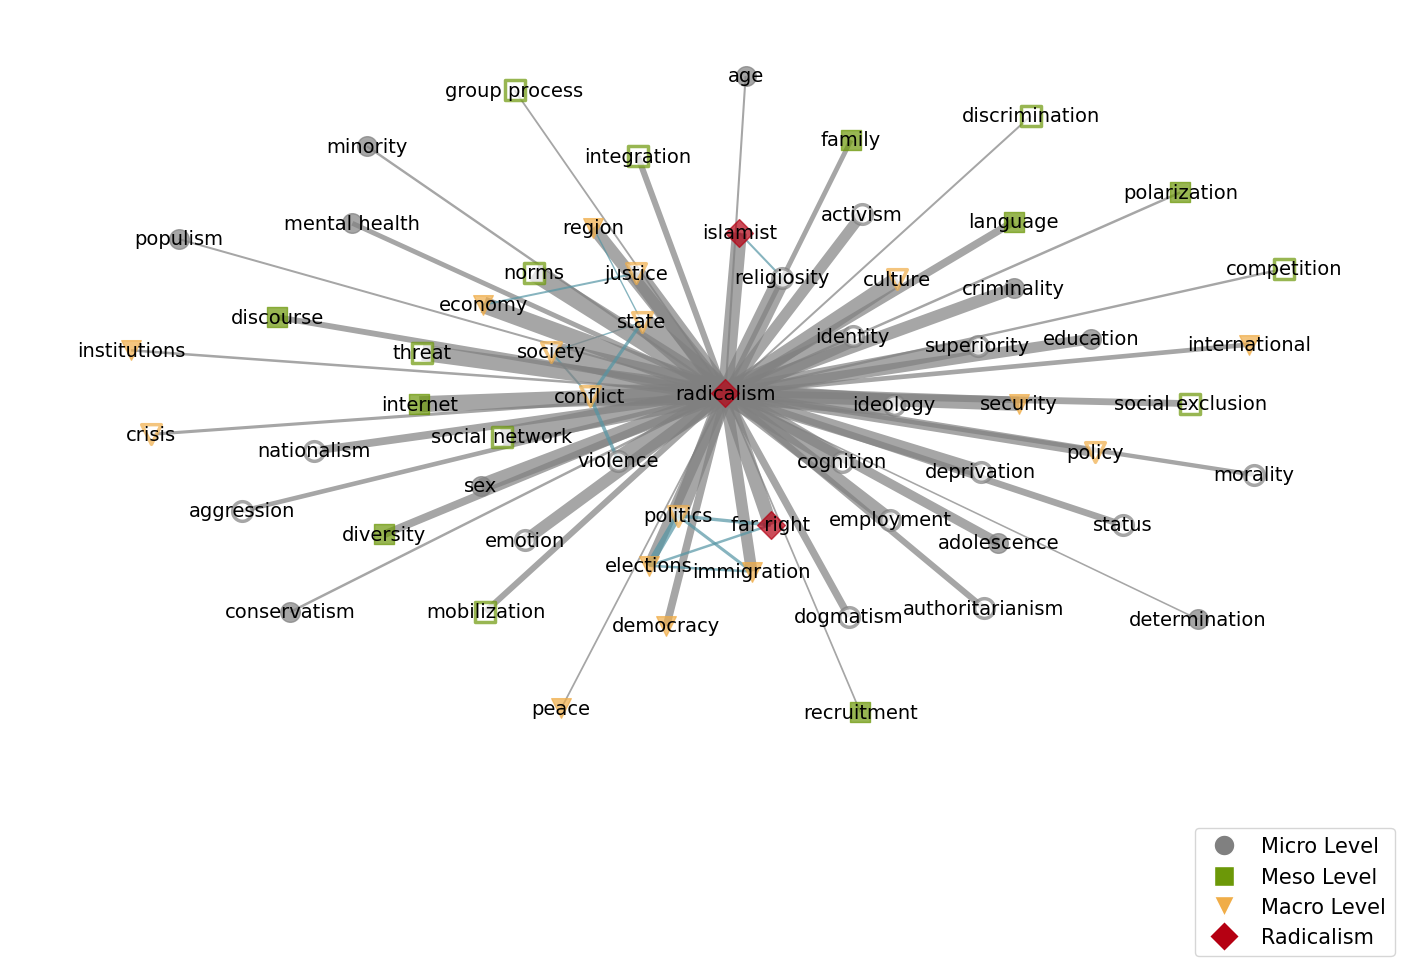

In [60]:
# Define terms for each category based on your categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "determination"
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience"
]

radicalism_nodes = ["radicalism", "far right", "islamist"]

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_incl.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Draw nodes with shape based on their category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

# Updated color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['radicalism'], node_shape='D', linewidths=2.5, alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors: grey if connected to radicalism, otherwise black
edge_colors = ['grey' if 'radicalism' in (u, v) else '#5495a4' for u, v in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=15, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=15, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=15, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=15, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right', fontsize=15, markerscale=1, bbox_to_anchor=(1, -0.05))

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_radicalism.png', bbox_inches='tight', dpi=600)
plt.show()


#### b) Without "radicalism"

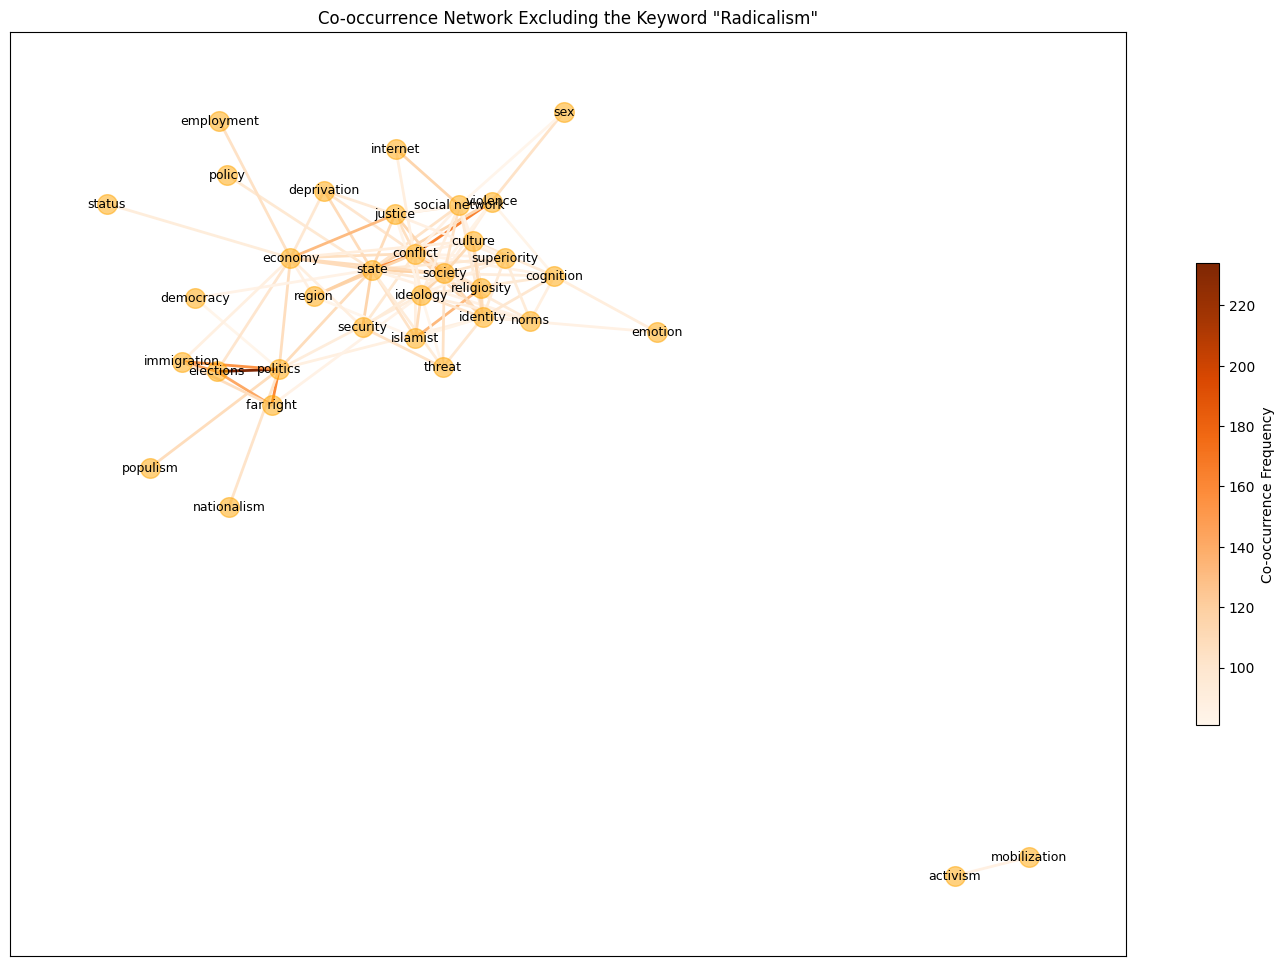

In [61]:
# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_excl.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 12))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Draw nodes with color
#highlight_nodes = ['adolescence'] + list(G.neighbors("adolescence"))
colors = "orange" #['orange' if node not in highlight_nodes else 'darkviolet' for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, alpha = 0.5)

# Draw edges with width and color proportional to the frequency
# Normalize frequencies to get a color gradient
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

#mean_weight = np.mean(weights)
#std_weight = np.std(weights)
#normalized_weights = [(weight - mean_weight) / std_weight for weight in weights]



# Create a color map
cmap = plt.cm.Oranges

edges = nx.draw_networkx_edges(
    G, pos, 
    edge_color= weights, #normalized_weights, 
    width= 2, #[2 + 4*weight for weight in normalized_weights],  # adjust the width for better visualization
    edge_cmap=cmap
)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_family="sans-serif")

plt.title('Co-occurrence Network Excluding the Keyword "Radicalism"')
plt.colorbar(edges, label='Co-occurrence Frequency', shrink=0.5)
#plt.axis('off')  # Turn off the axis
plt.show()

#### c) Centred around "adolescence"

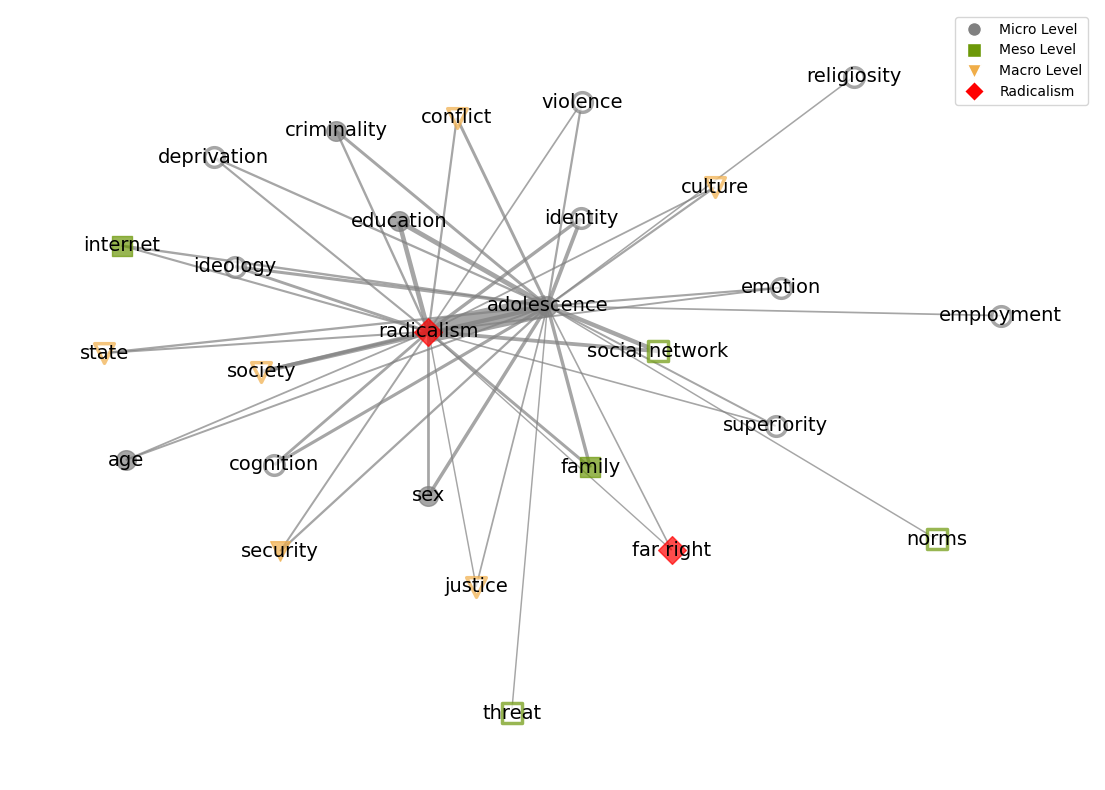

In [62]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["radicalism", "far right"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_ado.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=2, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'adolescence'
if 'adolescence' in pos and 'radicalism' in pos:
    pos['adolescence'][0] += 0.1  # Adjust x position
    pos['adolescence'][1] += 0.1  # Adjust y position

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': 'red'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_adolescence.png', bbox_inches='tight', dpi=600)
plt.show()


In [63]:
#without radicalism

#### d) Centred around "islamist"

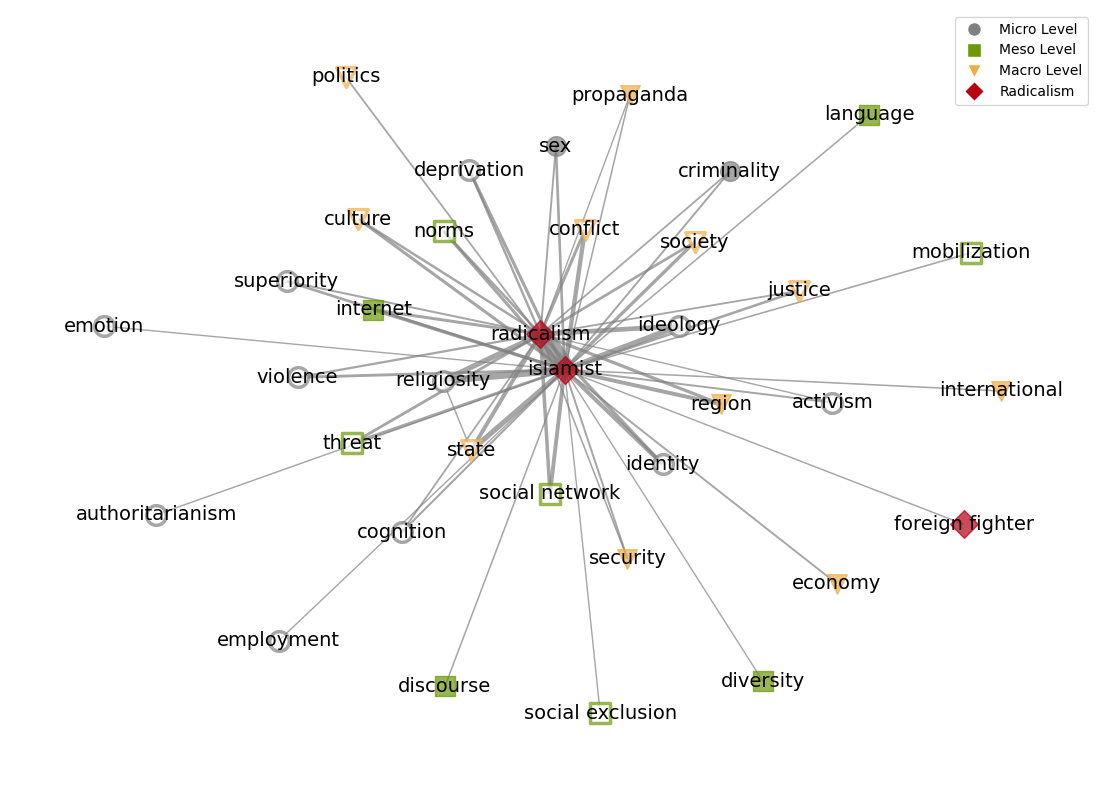

In [64]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["radicalism", "islamist", "foreign fighter"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_islamist.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=1.5, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'islamist'
if 'islamist' in pos:
    pos['islamist'][1] += 0.002  # Adjust y position slightly by 2 mm
if 'radicalism' in pos:
    pos['radicalism'][1] -= 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_Islamist.png', bbox_inches='tight', dpi=600)
plt.show()


In [65]:
#without radicalism

#### e) Centred around "far right"

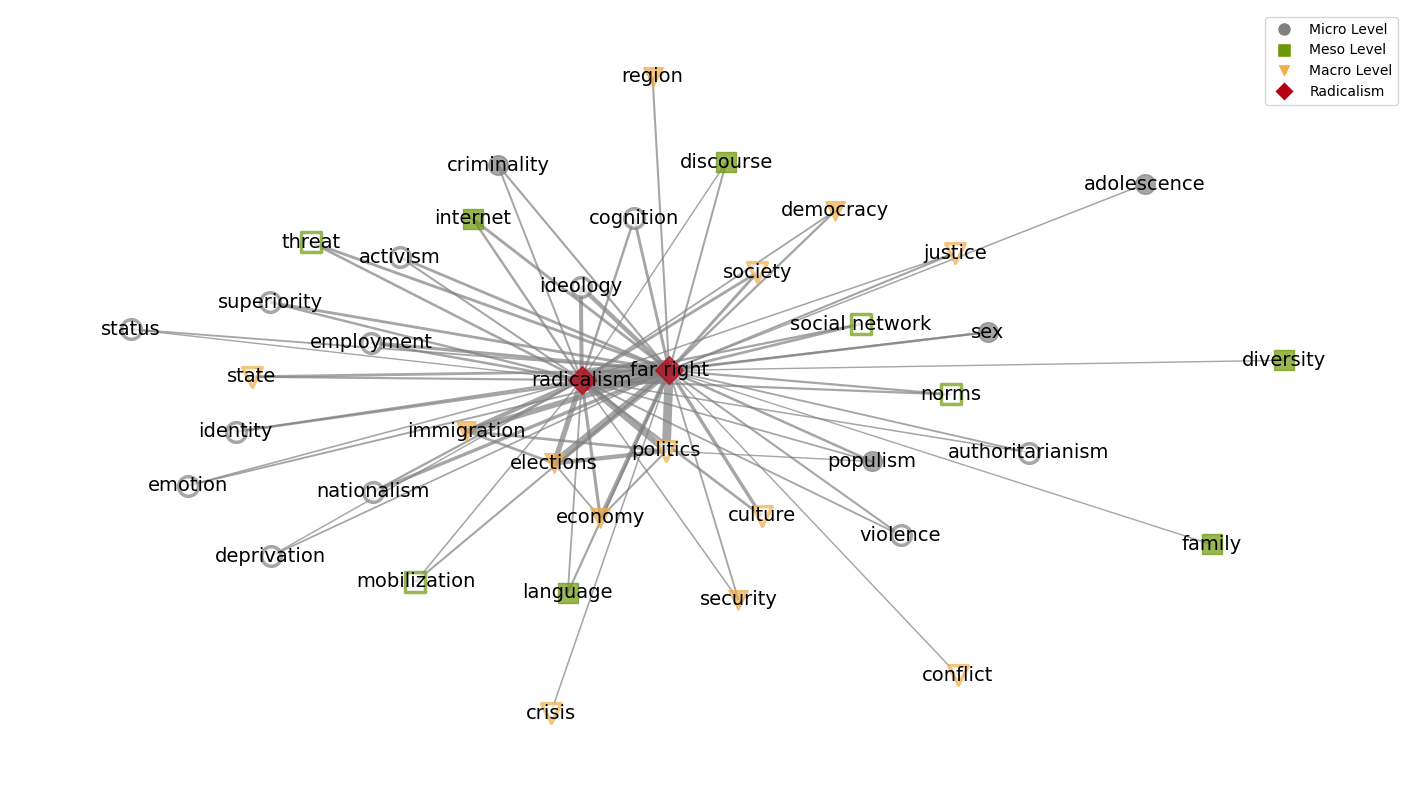

In [66]:
# Define terms for each category based on categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "misogyny",
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change",
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience"
]

radicalism_nodes = ["radicalism", "far right"]

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_right.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Manually adjust positions to prevent overlap of "far right" and "radicalism"
if "far right" in pos and "radicalism" in pos:
    pos["far right"][0] += 0.1  # Adjust x position
    pos["far right"][1] += 0.1  # Adjust y position

# Draw nodes with shape based on their category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

# Updated color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['radicalism'], node_shape='D', linewidths=2.5, alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors to a single color (e.g., grey)
edge_colors = ['grey' for _ in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_farright.png', bbox_inches='tight', dpi=600)
plt.show()


In [67]:
#### f) Excluding the term radicalism

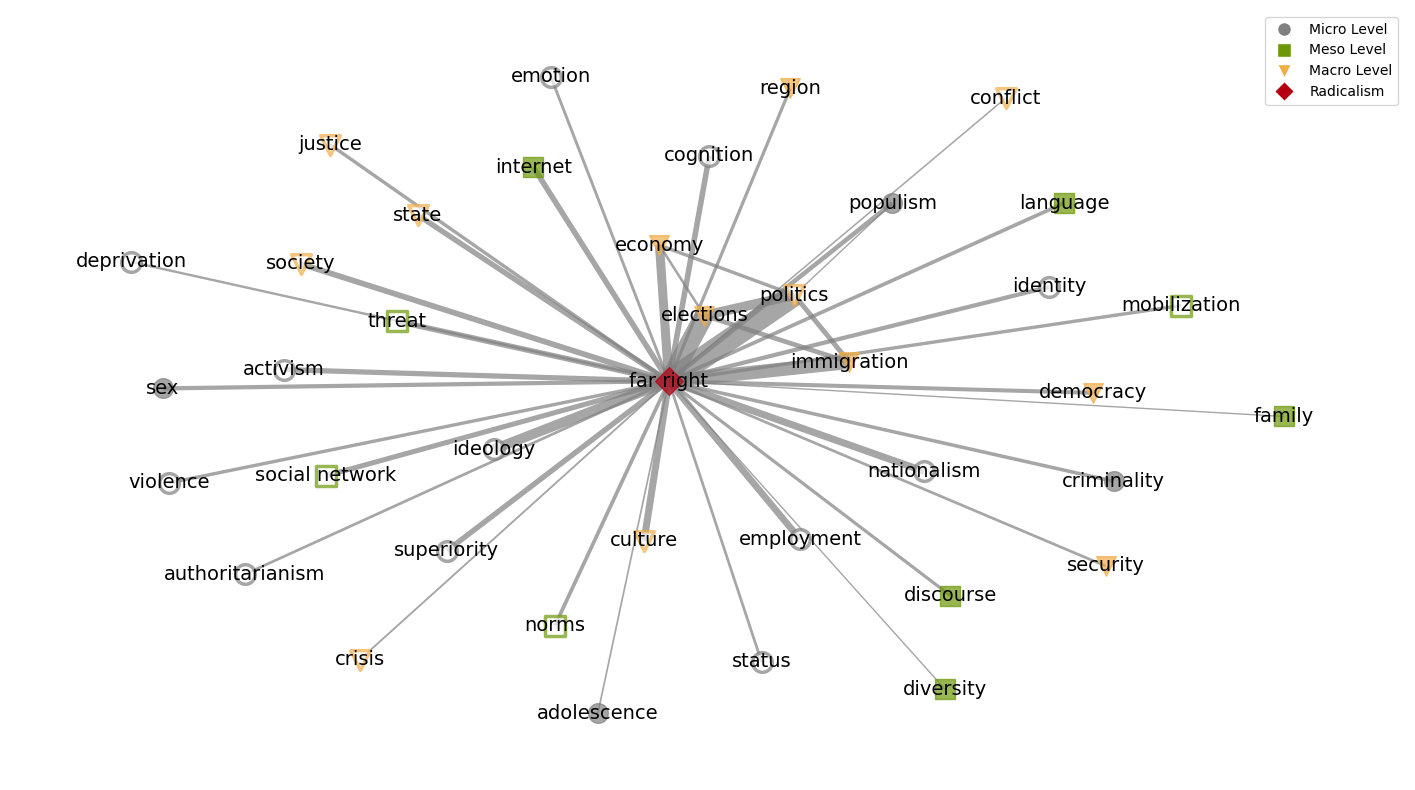

In [68]:
# Define terms for each category based on your categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
    "islamophobia", "significance quest", "social movements", "masculinity", 
    "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
    "ptsd", "resilience", "voting behavior", "misogyny",
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "norms", "internet",
    "mobilization", "discourse", "integration", "family", "competition", "language",
    "polarization", "discrimination", "group process", "recruitment", 
    "elites", "social media", "social cohesion", "social change"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", 
    "culture", "security", "region", "elections", "policy", "democracy", 
    "international", "crisis", "institutions", "peace", "propaganda", 
    "military", "globalization", "immigration"
]

theory_terms = [
    "ideology", "violence", "social network", "conflict", "religiosity", "state", 
    "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
    "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
    "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
    "authoritarianism", "integration", "aggression", "morality", "competition", 
    "crisis", "sacred values", "discrimination", "group process", "rationality", 
    "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
    "honor", "poverty", "significance quest", "social movements", "globalization", 
    "martyrdom", "political engagement", "resilience"
]

radicalism_terms = ['far right']

# Create the graph
G = nx.Graph()

# Add edges with the corresponding frequency as the weight
for index, row in cooc_df_right.iterrows():
    if row['term1'] != "radicalism" and row['term2'] != "radicalism":
        G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

# Draw the graph
plt.figure(figsize=(18, 10))

# Use spring layout for better visualization
pos = nx.spring_layout(G, seed=43, k=2, iterations=100, scale=2)  # positions for all nodes

# Draw nodes with shape based on their category
micro_nodes = [node for node in G.nodes() if node in micro_terms]
meso_nodes = [node for node in G.nodes() if node in meso_terms]
macro_nodes = [node for node in G.nodes() if node in macro_terms]

# Updated color mapping for shapes
color_mapping = {
    'micro': 'grey',  # Grey
    'meso': '#6c9808',   # Green
    'macro': '#f0ad48',  # Orange
    'radicalism': '#b50012'  # Red
}

# Draw micro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['micro'], node_shape='o', alpha=0.7, label='Micro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in micro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['micro'], node_shape='o', linewidths=2.5, alpha=0.7, label='Micro Level')

# Draw meso nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['meso'], node_shape='s', alpha=0.7, label='Meso Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in meso_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['meso'], node_shape='s', linewidths=2.5, alpha=0.7, label='Meso Level')

# Draw macro nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node not in theory_terms], node_size=200, node_color=color_mapping['macro'], node_shape='v', alpha=0.7, label='Macro Level')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in macro_nodes if node in theory_terms], node_size=200, node_color='white', edgecolors=color_mapping['macro'], node_shape='v', linewidths=2.5, alpha=0.7, label='Macro Level')

# Draw radicalism nodes
nx.draw_networkx_nodes(G, pos, nodelist=[node for node in radicalism_terms], node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7, label='Radicalism')

# Draw edges with width and color proportional to the frequency
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]  # Increase contrast in thickness

# Set edge colors to a single color (e.g., grey)
edge_colors = ['grey' for _ in G.edges]

# Draw edges
edges = nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.7
)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend for node shapes
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_farright_excluding_radicalism.png', bbox_inches='tight', dpi=600)
plt.show()


#### f) Centred around "far left"

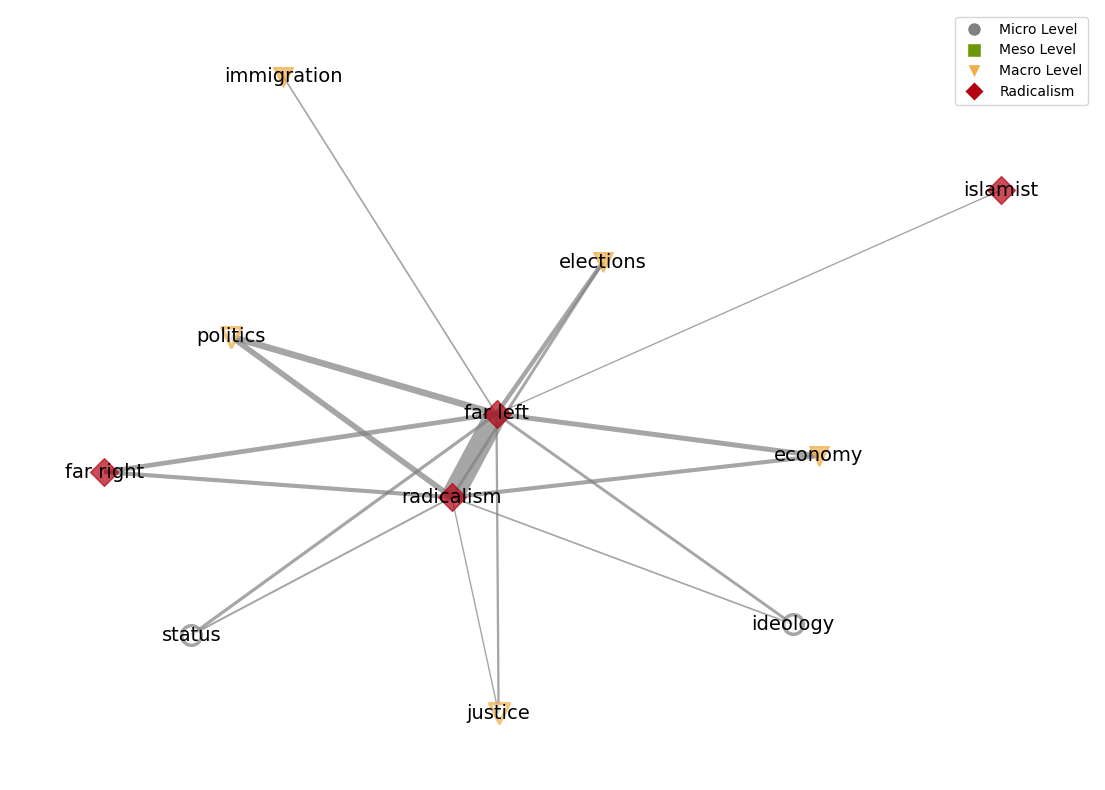

In [69]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["radicalism", "far left", "islamist", "far right"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_left.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=1.5, iterations=100)  # positions for all nodes

# Adjust positions to separate 'radicalism' and 'far left'
if 'far left' in pos:
    pos['far left'][1] += 0.002  # Adjust y position slightly by 2 mm
if 'radicalism' in pos:
    pos['radicalism'][1] -= 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')


# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_farleft.png', bbox_inches='tight', dpi=600)
plt.show()


In [70]:
#excluding radicalism

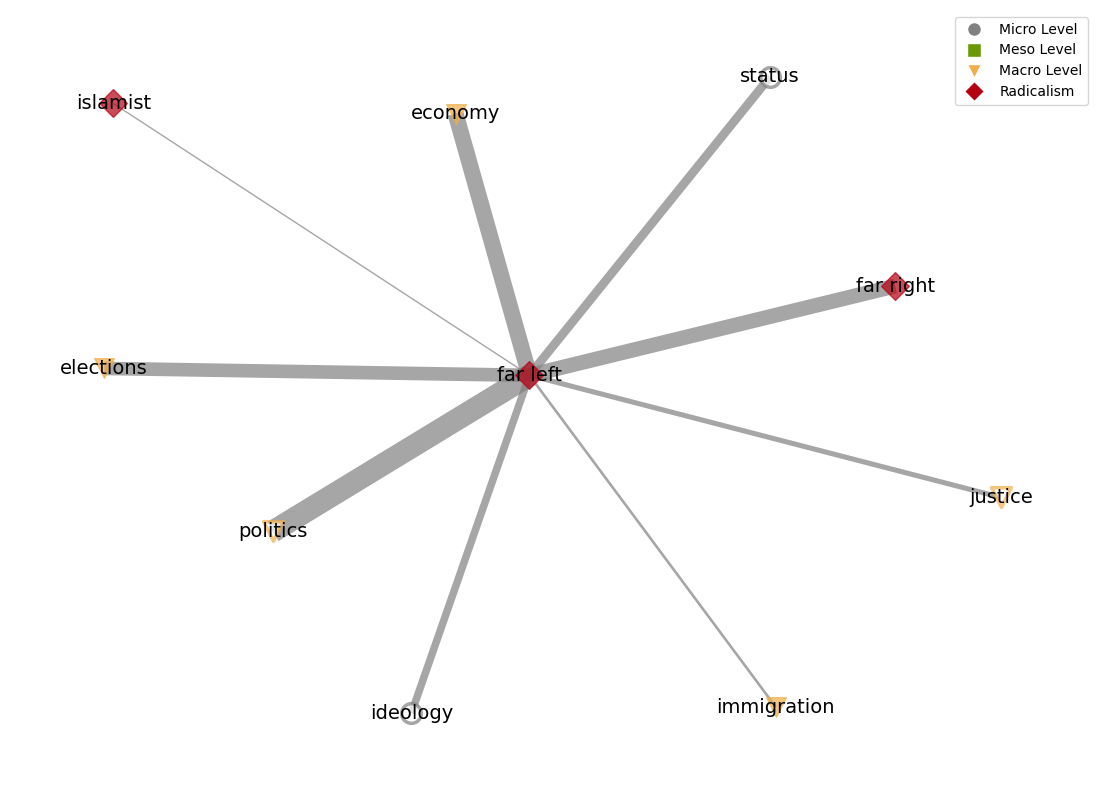

In [71]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["far left", "islamist", "far right"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_left.iterrows():
    if 'radicalism' not in (row['term1'], row['term2']):
        G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=0.3, iterations=300)  # positions for all nodes, more compact layout

# Adjust positions to separate 'far left' and other nodes
if 'far left' in pos:
    pos['far left'][1] += 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_farleft.png', bbox_inches='tight', dpi=600)
plt.show()


#### g) Centred around "lone actor"

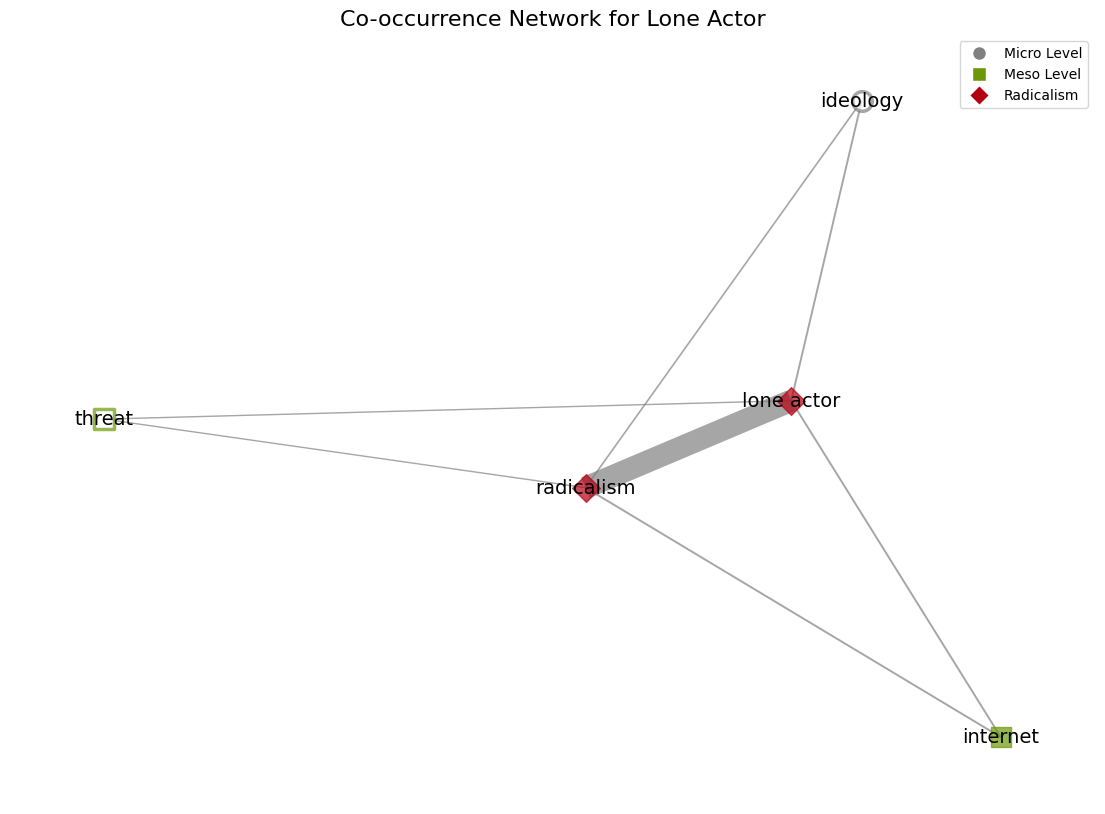

In [72]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["lone actor", "radicalism"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_lone.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=0.3, iterations=300)  # positions for all nodes

# Adjust positions to separate 'lone actor' and other nodes if necessary
if 'lone actor' in pos:
    pos['lone actor'][1] += 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = categories['radicalism']

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Co-occurrence Network for Lone Actor', fontsize=16)
plt.savefig('RTMR_Output/abstracts_cooccurence_loneactor.png', bbox_inches='tight', dpi=600)
plt.show()


In [73]:
# without radicalism

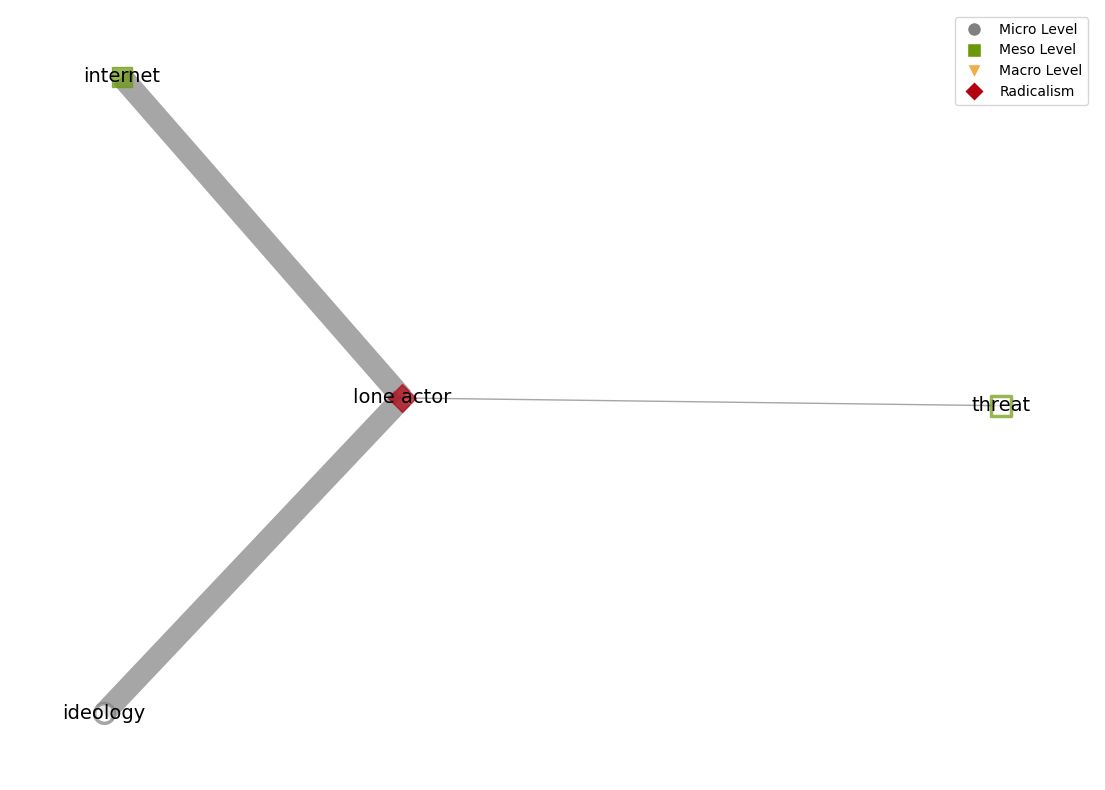

In [74]:
# Define terms for each category based on your categorization
categories = {
    'micro': [
        "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
        "sex", "employment", "deprivation", "emotion", "activism", 
        "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
        "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
        "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
        "uncertainty", "trust", "personality", "liberalism", "intolerance", 
        "fundamentalism", "fear", "honor", "poverty", "white race", "superiority",
        "islamophobia", "significance quest", "social movements", "masculinity", 
        "conspiracy", "misogyny", "racism", "martyrdom", "political engagement", 
        "ptsd", "resilience", "voting behavior", "misogyny"
    ],
    'meso': [
        "social network", "threat", "diversity", "social exclusion", "norms", "internet",
        "mobilization", "discourse", "integration", "family", "competition", "language",
        "polarization", "discrimination", "group process", "recruitment", 
        "elites", "social media", "social cohesion", "social change"
    ],
    'macro': [
        "conflict", "state", "economy", "society", "politics", "justice", 
        "culture", "security", "region", "elections", "policy", "democracy", 
        "international", "crisis", "institutions", "peace", "propaganda", 
        "military", "globalization", "immigration"
    ],
    'theory': [
        "ideology", "violence", "social network", "conflict", "religiosity", "state", 
        "society", "identity", "politics", "cognition", "justice", "norms", "culture", 
        "threat", "superiority", "employment", "deprivation", "emotion", "activism", 
        "policy", "nationalism", "social exclusion", "status", "dogmatism", "mobilization", 
        "authoritarianism", "integration", "aggression", "morality", "competition", 
        "crisis", "sacred values", "discrimination", "group process", "rationality", 
        "prejudice", "uncertainty", "intolerance", "military", "fundamentalism", 
        "honor", "poverty", "significance quest", "social movements", "globalization", 
        "martyrdom", "political engagement", "resilience"
    ],
    'radicalism': ["lone actor"]
}

# Create the graph
G = nx.Graph()
for index, row in cooc_df_lone.iterrows():
    if row['term1'] != "radicalism" and row['term2'] != "radicalism":
        G.add_edge(row['term1'], row['term2'], weight=row['cooc'])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=43, k=0.3, iterations=300)  # positions for all nodes

# Adjust positions to separate 'lone actor' and other nodes if necessary
if 'lone actor' in pos:
    pos['lone actor'][1] += 0.002  # Adjust y position slightly by 2 mm

# Color mapping
color_mapping = {
    'micro': 'grey',
    'meso': '#6c9808',
    'macro': '#f0ad48',
    'radicalism': '#b50012'
}

highlight_nodes = [node for node in categories['radicalism'] if node != "radicalism"]

# Draw nodes
for category, nodes in categories.items():
    if category != 'theory':
        node_shape = 'o' if category == 'micro' else ('s' if category == 'meso' else ('v' if category == 'macro' else 'D'))
        color = color_mapping[category]
        non_theory_nodes = [node for node in G.nodes() if node in nodes and node not in highlight_nodes and node not in categories['theory']]
        theory_nodes = [node for node in G.nodes() if node in nodes and node in categories['theory']]
        nx.draw_networkx_nodes(G, pos, nodelist=non_theory_nodes, node_size=200, node_color=color, node_shape=node_shape, alpha=0.7)
        nx.draw_networkx_nodes(G, pos, nodelist=theory_nodes, node_size=200, node_color='white', edgecolors=color, node_shape=node_shape, linewidths=2.5, alpha=0.7)

# Draw highlight nodes
nx.draw_networkx_nodes(G, pos, nodelist=highlight_nodes, node_size=200, node_color=color_mapping['radicalism'], node_shape='D', alpha=0.7)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges]
min_weight = min(weights)
max_weight = max(weights)
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
edge_widths = [1 + 15 * norm_weight for norm_weight in normalized_weights]
edges = nx.draw_networkx_edges(G, pos, edge_color='grey', width=edge_widths, alpha=0.7)

# Draw labels with increased font size
nx.draw_networkx_labels(G, pos, font_size=14, font_family="sans-serif")

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping['micro'], markersize=10, label='Micro Level'),
    plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color_mapping['meso'], markersize=10, label='Meso Level'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor=color_mapping['macro'], markersize=10, label='Macro Level'),
    plt.Line2D([0], [0], marker='D', color='w', markerfacecolor=color_mapping['radicalism'], markersize=10, label='Radicalism')
]

plt.legend(handles=legend_elements, loc='upper right')

# Remove the frame
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('RTMR_Output/abstracts_cooccurence_loneactor_excluding_radicalism.png', bbox_inches='tight', dpi=600)
plt.show()


### III. Comparison between Study 1 (Keywords) and Study 2 (Abstract)

**Overlapping terms for frequencies**

In [75]:
freq_df_st1 = pd.read_csv(r"RTMR_Output/Keywords_freq_study1.csv").sort_values(by= "Frequency", ascending=False).reset_index()
freq_df_st2 = pd.read_csv(r"RTMR_Output/Keywords_freq_study2.csv").sort_values(by= "Frequency", ascending=False).reset_index()

In [76]:
print("Percentage of overlapping terms, based on study 1: ", len( set(freq_df_st1.Word).intersection(set(freq_df_st2.Word)) ) / len(freq_df_st1.Word) )
print("Percentage of overlapping terms, based on study 2: ", len( set(freq_df_st1.Word).intersection(set(freq_df_st2.Word)) ) / len(freq_df_st2.Word) )
print("Absolute number of overlapping terms: ", len( set(freq_df_st1.Word).intersection(set(freq_df_st2.Word)) ))

Percentage of overlapping terms, based on study 1:  0.8024691358024691
Percentage of overlapping terms, based on study 2:  0.8333333333333334
Absolute number of overlapping terms:  65


In [77]:
## Unique terms per analysis

print("Unique terms in KW analysis: \n", set(freq_df_st1.Word).difference(set(freq_df_st2.Word)))
print("\nUnique terms in Abstract analysis: \n", set(freq_df_st2.Word).difference(set(freq_df_st1.Word)))

Unique terms in KW analysis: 
 {'white race', 'racism', 'far left', 'significance quest', 'globalization', 'martyrdom', 'poverty', 'political engagement', 'conspiracy', 'resilience', 'foreign fighter', 'social change', 'male supremacist', 'masculinity', 'islamophobia', 'social movements'}

Unique terms in Abstract analysis: 
 {'policy', 'region', 'military', 'conservatism', 'liberalism', 'dogmatism', 'fear', 'age', 'elites', 'determination', 'institutions', 'recruitment', 'international'}


## Mental Health occurrences across timeline

In [78]:
year_df = dfTot[["record_id","Publication Year"]]

In [79]:
study1 = pd.read_json("RTMR_Output/clean_data_study1.json")
study2 = clean_data.drop(columns = ["cat_keywords"])

In [80]:
merged_df = pd.merge(study1, study2, on='record_id', how='outer')
merged_df = pd.merge(year_df, merged_df, on='record_id', how='outer')
merged_df

,record_id,Publication Year,keywords_x,cat_keywords,abstract,ngram,trigrams,residual_ngrams,bigrams,resid_onegrams,keywords_y,cat_keywords2
0,50129,2022,"[goal shielding, passion, radicalization, sign...","[passion, radicalism, significance quest, goal...","[relationship, passion, ideology, violent, act...","[[relationship passion ideology, relationship ...","[collective loss significance, obsessive harmo...","[relationship passion, passion ideology, ideol...","[violent activism, significance gain, personal...","[cost, passion, relevance, programme, unrelate...","[cost, violent activism, passion, relevance, o...","[passion, radicalism, support violent, activis..."
1,2624,2018,"[suicide attacks, extremism, radicalization, r...","[radicalism, fundamentalism]","[religion, main, extremist, violence, suicide,...","[[religion main extremist, religion main], [ma...",[support extremist violence],"[religion main, main extremist, extremist viol...","[religiosity religious, suicide attack, religi...","[important, final, religion, fundamentalism, a...","[aspect, suicide attack, small, main, multinat...","[attack relationship, radicalism, diversity, r..."
2,35510,2018,"[social neuroscience, political neuroscience, ...","[radicalism, political neuroscience, microsoci...","[capable, andor, act, political, violence, att...","[[capable andor act, capable andor], [andor ac...","[extreme political violence, radicalization po...","[capable andor, andor act, nan, violence attac...","[violence attack, extreme violence, support ex...","[potential, situational, latent, multiple, cap...","[potential, situational, latent, multiple, cap...","[integration, cognition, employment, radicalis..."
3,43427,2013,NaN,NaN,"[dutch, muslim, youth, radicalization, main, p...","[[dutch muslim youth, dutch muslim], [muslim y...",[],"[dutch muslim, muslim youth, youth radicalizat...","[radical belief, muslim youth, youth radicaliz...","[important, feel, society, turn, structural, a...","[superiority, personal uncertainty, violence v...","[superiority, emotion, violence violent, uncer..."
4,986,2023,NaN,NaN,"[prominence, understand, extent, identity, ext...","[[prominence understand extent, prominence und...",[],"[prominence understand, understand extent, ext...","[identity extremist, identity extremism, extre...","[radicalization, identity, majority, many, mot...","[personal, extremist radicalization, radicaliz...","[identity, radicalism]"
...,...,...,...,...,...,...,...,...,...,...,...,...
4014,24073,2017,"[right wing extremism, fascism, women, golden ...","[sex, far right, radicalism, nationalism, habi...","[place, woman, ideology, greek, neo, political...","[[place woman ideology, place woman], [woman i...",[],"[place woman, woman ideology, ideology greek, ...","[woman participation, participation woman, pol...","[official, evident, woman, edifice, key, const...","[woman participation, official, evident, woman...","[ideology, family, nationalism, politics, soci..."
4015,22510,2018,NaN,NaN,"[islamist, militancy, new, many, active, outbr...","[[islamist militancy new, islamist militancy],...",[],"[islamist militancy, militancy new, new many, ...","[integral part, foreign policy, islamist milit...","[regime, policy, uprising, emergence, ecumenic...","[outbreak, rise radical, active, many, early, ...","[radicalism, integral part, apocalypticism, fo..."
4016,50382,1994,"[goal setting, goal formation, personality, so...","[personality, goal formation, social attitudes...","[long, term, set, semantic, aspect, set, help,...","[[long term set, long term], [term set semanti...",[],"[long term, term set, set semantic, semantic a...","[long term, social attitude, personal signific...","[originality, aspect, mode, semantic, conserva...","[originality, long term, aspect, mode, degree,...","[long term, significance quest, conservatism, ..."
4017,2188,2022,"[pai teaching materials, religious tolerance, ...","[intolerance, school, pai teaching materials, ...","[effectiveness, inclus

In [81]:
# Replace NaN values with empty lists
merged_df['cat_keywords'] = merged_df['cat_keywords'].apply(lambda x: x if isinstance(x, list) else [])
merged_df['cat_keywords2'] = merged_df['cat_keywords2'].apply(lambda x: x if isinstance(x, list) else [])


In [82]:
articles_per_year = Counter(merged_df["Publication Year"])

In [83]:
check_term = "mental health"

In [84]:
rels = merged_df[merged_df['cat_keywords'].apply(lambda x: check_term in x) | merged_df['cat_keywords2'].apply(lambda x: check_term in x)]
mental_health_per_year = Counter(rels["Publication Year"])

In [85]:
corrected_years = dict()
for key, value in mental_health_per_year.items():
    corrected_years[key] = value / articles_per_year[key]

corrected_years = dict(sorted(corrected_years.items()))

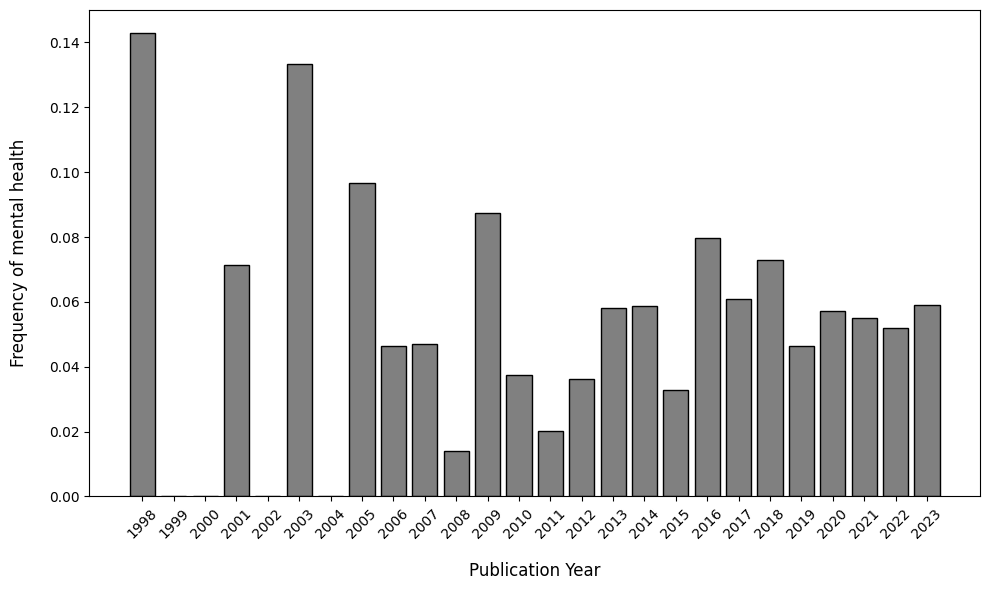

In [86]:
# Determine the range of years
min_year = min(corrected_years.keys())
max_year = max(corrected_years.keys())

# Create a list of all years in the range
all_years = list(range(min_year, max_year + 1))

# Get the frequencies for all years, using 0 for years with no data
frequencies = [corrected_years.get(year, 0) for year in all_years]

# Plot the histogram
plt.figure(figsize=(10, 6))

plt.bar(all_years, frequencies, edgecolor='black', color='gray')

# Customize the x-axis labels for better detail
plt.xticks(all_years, rotation=45)  # Rotate labels to 45 degrees
plt.xlabel('Publication Year', fontsize=12, labelpad=15)  # Add padding
plt.ylabel(f'Frequency of {check_term}', fontsize=12, labelpad=15)  # Add padding

# Remove the background grid
plt.grid(False)

# Save
plt.savefig('RTMR_Output/abstracts_mentalhealth_hist.png', bbox_inches='tight', dpi=600)


# Show the plot
plt.tight_layout()
plt.show()


## Terms not occurring in co-occurrence

In [87]:
print("Terms not occurring in co-occurrnece maps: \n", set(list(freq_df.Word)).difference(set(list(cooc_df_incl.term1) + list(cooc_df_incl.term2))))

Terms not occurring in co-occurrnece maps: 
 {'rationality', 'trust', 'fundamentalism', 'hate', 'military', 'intolerance', 'fear', 'uncertainty', 'prejudice', 'liberalism', 'elites', 'social cohesion', 'propaganda', 'social media', 'personality', 'lone actor'}


## Binomial test for within vs. between category co-occurrences

In [88]:
data_chi = cooc_df_excl.copy(deep=True)
data_chi

,term1,term2,cooc,id
0,politics,elections,234,electionspolitics
1,violence,conflict,163,conflictviolence
2,politics,far right,159,far rightpolitics
3,state,conflict,157,conflictstate
4,politics,immigration,153,immigrationpolitics
...,...,...,...,...
102,threat,ideology,82,ideologythreat
103,superiority,culture,81,culturesuperiority
104,region,islamist,81,islamistregion
105,social network,justice,81,justicesocial network


In [89]:
# Define terms for each category based on your updated categorization
micro_terms = [
    "ideology", "violence", "religiosity", "adolescence", "identity", "cognition", 
    "sex", "employment", "deprivation", "immigration", "emotion", "activism", 
    "criminality", "education", "nationalism", "populism", "status", "dogmatism", 
    "authoritarianism", "aggression", "morality", "mental health", "conservatism", 
    "minority", "sacred values", "age", "hate", "rationality", "prejudice", 
    "uncertainty", "trust", "personality", "liberalism", "intolerance", 
    "fundamentalism", "fear", "honor", "poverty", "white race", "superiority", 
]

meso_terms = [
    "social network", "threat", "diversity", "social exclusion", "discourse", 
    "family", "competition", "polarization", "discrimination", "group process", 
    "recruitment", "elites", "social media", "social coherence", "mobilization", 
    "integration"
]

macro_terms = [
    "conflict", "state", "economy", "society", "politics", "justice", "norms", 
    "culture", "internet", "security", "region", "elections", "policy", "democracy", 
    "language", "international", "crisis", "institutions", "peace", "propaganda", 
    "military"
]

# Function to categorize terms
def categorize_terms(term):
    if term in micro_terms:
        return 'micro'
    elif term in meso_terms:
        return 'meso'
    elif term in macro_terms:
        return 'macro'
    else:
        return 'unknown'

In [90]:
# Apply categorization to terms
data_chi['category1'] = data_chi['term1'].apply(categorize_terms)
data_chi['category2'] = data_chi['term2'].apply(categorize_terms)

# Filter out unknown categories
cooc_df_filtered = data_chi[(data_chi['category1'] != 'unknown') & (data_chi['category2'] != 'unknown')]
cooc_df_filtered

,term1,term2,cooc,id,category1,category2
0,politics,elections,234,electionspolitics,macro,macro
1,violence,conflict,163,conflictviolence,micro,macro
3,state,conflict,157,conflictstate,macro,macro
4,politics,immigration,153,immigrationpolitics,macro,micro
6,immigration,elections,141,electionsimmigration,micro,macro
...,...,...,...,...,...,...
101,politics,democracy,82,democracypolitics,macro,macro
102,threat,ideology,82,ideologythreat,meso,micro
103,superiority,culture,81,culturesuperiority,micro,macro
105,social network,justice,81,justicesocial network,meso,macro


In [91]:
## how often do the levels occurr
freq_levels = Counter(list(cooc_df_filtered.category1) + list(cooc_df_filtered.category2))
total_nodes = np.sum(list(freq_levels.values()))
for key, value in freq_levels.items():
    freq_levels[key] = value / total_nodes
freq_levels

Counter({'macro': 0.5463917525773195,
         'micro': 0.36597938144329895,
         'meso': 0.08762886597938144})

In [92]:
corrected_cooc = []
total_edges = cooc_df_filtered.cooc.sum()
for idx in cooc_df_filtered.index:
    corrected_cooc.append( (cooc_df_filtered.loc[idx, "cooc"] / total_edges) / (freq_levels[cooc_df_filtered.loc[idx, "category1"]] * freq_levels[cooc_df_filtered.loc[idx, "category2"]]))

cooc_df_filtered["corrected_cooc"] = corrected_cooc
cooc_df_filtered

C:\Users\495235\AppData\Local\Temp\ipykernel_23376\3569895636.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cooc_df_filtered["corrected_cooc"] = corrected_cooc


,term1,term2,cooc,id,category1,category2,corrected_cooc
0,politics,elections,234,electionspolitics,macro,macro,0.079687
1,violence,conflict,163,conflictviolence,micro,macro,0.082872
3,state,conflict,157,conflictstate,macro,macro,0.053465
4,politics,immigration,153,immigrationpolitics,macro,micro,0.077788
6,immigration,elections,141,electionsimmigration,micro,macro,0.071687
...,...,...,...,...,...,...,...
101,politics,democracy,82,democracypolitics,macro,macro,0.027925
102,threat,ideology,82,ideologythreat,meso,micro,0.259951
103,superiority,culture,81,culturesuperiority,micro,macro,0.041182
105,social network,justice,81,justicesocial network,meso,macro,0.171995


In [93]:
n = cooc_df_filtered.cooc.sum()
n

9836

In [94]:
occ_within = cooc_df_filtered.cooc[cooc_df_filtered.category1 == cooc_df_filtered.category2].sum()
occ_between = cooc_df_filtered.cooc[cooc_df_filtered.category1 != cooc_df_filtered.category2].sum()
print("within: ",occ_within)
print("between: ", occ_between)

within:  4300
between:  5536


In [95]:
occ_within = cooc_df_filtered.cooc[cooc_df_filtered.category1 == cooc_df_filtered.category2].sum()
occ_between = cooc_df_filtered.cooc[cooc_df_filtered.category1 != cooc_df_filtered.category2].sum()
print("within: ",occ_within)
print("between: ", occ_between)

within:  4300
between:  5536


In [96]:
print(f"Contingency Table:\n\n   within between\nyes {np.array(observed)[0]}\nno  {np.array(observed)[1]}")

NameError: name 'observed' is not defined

In [ ]:
from scipy.stats import binom_test
print(binom_test(x=occ_between, n= n, p=1/2))
print(binom_test(x=occ_within, n= n, p=1/2))
